In [1]:
import keras
keras.__version__

'2.4.3'

In [2]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()



57344/57026 [==============================] - 0s 0us/step


In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

As you can see, we have 404 training samples and 102 test samples. The data comprises 13 features. The 13 features in the input data are as follow:

* Per capita crime rate.
* Proportion of residential land zoned for lots over 25,000 square feet.
* Proportion of non-retail business acres per town.
* Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
* Nitric oxides concentration (parts per 10 million).
* Average number of rooms per dwelling.
* Proportion of owner-occupied units built prior to 1940.
* Weighted distances to five Boston employment centres.
* Index of accessibility to radial highways.
* Full-value property-tax rate per $10,000.
* Pupil-teacher ratio by town.
* 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
* % lower status of the population.

The targets are the median values of owner-occupied homes, in thousands of dollars.

In [5]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

In [6]:
# Note that the quantities that we use for normalizing the test data have been computed using the training data. 
# We should never use in our workflow any quantity computed on the test data, even for something as simple as data 
# normalization.


mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [8]:
train_data.shape[1]

13

In [7]:
from keras import models
from keras import layers

def build_model():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [9]:
# Validating our approach using K-fold validation

import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [10]:
all_scores

[2.0018739700317383, 2.75730037689209, 2.533428907394409, 2.898751735687256]

In [11]:
np.mean(all_scores)

2.5478387475013733

In [12]:
from keras import backend as K

# Some memory clean-up
K.clear_session()


In [14]:

num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
    

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [15]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

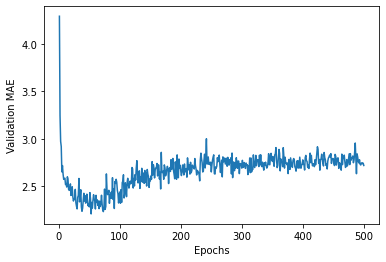

In [16]:

import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


According to this plot, it seems that validation MAE stops improving significantly after 80 epochs. Past that point, we start overfitting.

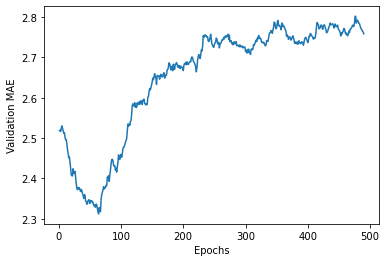

In [18]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


According to this plot, it seems that validation MAE stops improving significantly after 80 epochs. Past that point, we start overfitting.

In [19]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 5ms/step - loss: 15.5200 - mae: 2.5574


In [20]:
test_mae_score

2.557363986968994

We are still off by about $2,550.

Here's what you should take away from this example:

* Regression is done using different loss functions from classification; Mean Squared Error (MSE) is a commonly used loss function for regression.
* Similarly, evaluation metrics to be used for regression differ from those used for classification; naturally the concept of "accuracy" does not apply for regression. A common regression metric is Mean Absolute Error (MAE).
* When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.
* When there is little data available, using K-Fold validation is a great way to reliably evaluate a model.
* When little training data is available, it is preferable to use a small network with very few hidden layers (typically only one or two), in order to avoid severe overfitting.